In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from core.kernel import ARDKernel
import torch.optim as optim
import core.GP_CommonCalculation as GP
from data_sample import generate_example_data as data
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

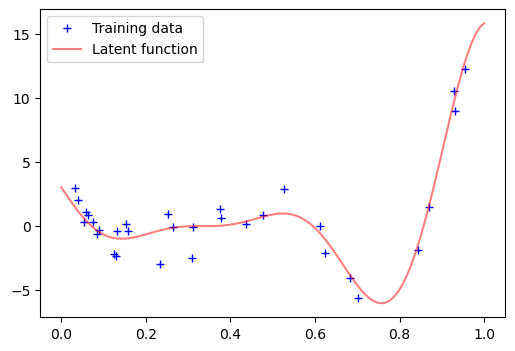

In [2]:
 # generate example data
xtr, ytr, xte, yte = data.generate(32, 100, seed=42)
data.plot(xtr, ytr, xte, yte, figsize=(6, 4))

In [3]:
normalizer = GP.DataNormalization(method="standard", mode=0, learnable=False)
normalizer.fit(xtr, 'xtr')
normalizer.fit(ytr, 'ytr')
xtr = normalizer.normalize(xtr, 'xtr')
ytr = normalizer.normalize(ytr, 'ytr')

In [4]:
kernel = ARDKernel(1)

In [5]:
#initiate_log_beta
log_beta = nn.Parameter(torch.ones(1) * -4)  # this is a large noise. we optimize to shrink it to a proper value.

In [6]:
def negative_log_likelihood(xtr, ytr, kernel, log_beta):
    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))
    return -GP.Gaussian_log_likelihood(ytr, Sigma)

In [7]:
def forward(xtr, ytr, xte, kernel, log_beta):
    n_test = xte.size(0)
    xte = normalizer.normalize(xte, 'xtr')
    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))

    K_s = kernel(xtr, xte)
    K_ss = kernel(xte, xte)

    mean, var = GP.conditional_Gaussian(ytr, Sigma, K_s, K_ss)

    var_diag = var.sum(dim=0).view(-1, 1)
    var_diag = var_diag + log_beta.exp().pow(-1)

    # Denormalize
    mean = normalizer.denormalize(mean, "ytr")
    var_diag = normalizer.denormalize_cov(var_diag, "ytr")
    return mean, var_diag

In [8]:
def train_adam(xtr, ytr, kernel, log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, kernel, log_beta)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
        #if param.requires_grad:
        #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
    print('iter', i, 'nll:{:.5f}'.format(loss.item()))

In [9]:
train_adam(xtr, ytr, kernel, log_beta, niteration=100, lr=0.1)

iter 99 nll:23.50842


In [10]:
with torch.no_grad():
    ypred, yvar = forward(xtr, ytr, xte, kernel, log_beta)

In [11]:
xtr = normalizer.denormalize(xtr, 'xtr')
ytr = normalizer.denormalize(ytr, 'ytr')

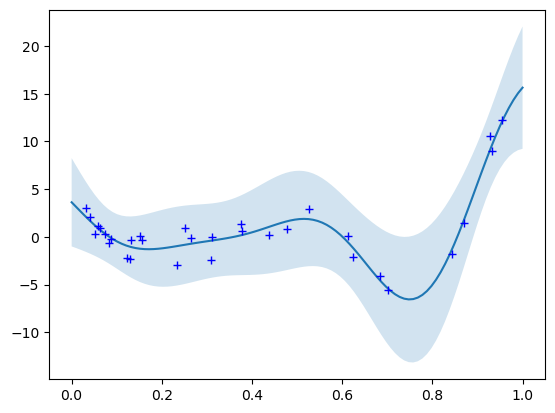

In [12]:
plt.fill_between(xte.squeeze().numpy(),
                 ypred.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.squeeze().detach().numpy()),
                 ypred.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), alpha=0.2,
                 label='95% Confidence interval')
plt.plot(xte.squeeze().numpy(), ypred.squeeze().detach().numpy(), label='Predictive mean')
plt.plot(xtr.detach().numpy(), ytr.detach().numpy(), 'b+')
plt.show()

iter 0 nll:588.80095
iter 10 nll:150.93247
iter 20 nll:31.71950
iter 30 nll:-33.95577
iter 40 nll:-38.68688
iter 50 nll:-48.13526
iter 60 nll:-49.87885
iter 70 nll:-50.39096
iter 80 nll:-50.49309
iter 90 nll:-50.64249
iter 100 nll:-50.70226
iter 110 nll:-50.75017
iter 120 nll:-50.77841
iter 130 nll:-50.80850
iter 140 nll:-50.83808
iter 150 nll:-50.86548
iter 160 nll:-50.89053
iter 170 nll:-50.91314
iter 180 nll:-50.93285
iter 190 nll:-50.94937


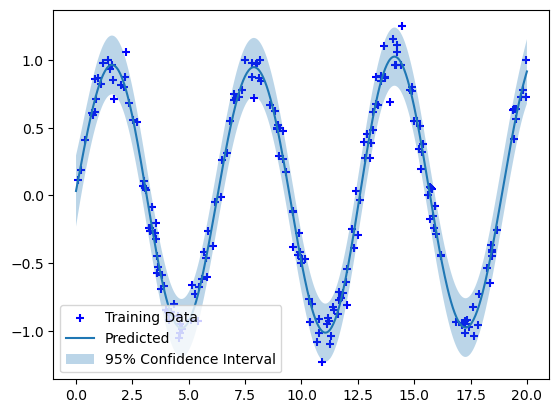

In [5]:
import torch
import torch.nn as nn
import time
import core.GP_CommonCalculation as GP
from data_sample import generate_example_data as data
from core.cigp_baseline import cigp
from core.kernel import NeuralKernel, ARDKernel
import matplotlib.pyplot as plt
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415
torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
xtr= torch.rand(200,1)*20
ytr= torch.sin(xtr)+torch.randn_like(xtr)*0.1
xte= torch.linspace(0,20,500).unsqueeze(-1)
yte= torch.sin(xte)+torch.randn_like(xte)*0.1

normalizer= GP.DataNormalization()
normalizer.fit(xtr,'x')
normalizer.fit(ytr,'y')
xtr_normalized= normalizer.normalize(xtr,'x')
ytr_normalized= normalizer.normalize(ytr,'y')
xte_normalized= normalizer.normalize(xte,'x')

model=cigp(kernel=NeuralKernel(1))
model.train_adam(xtr_normalized,ytr_normalized,200,1)
model.eval()
y_pred,yvar=model.forward(xtr_normalized,ytr_normalized,xte_normalized)
y_pred= normalizer.denormalize(y_pred,'y').detach()
yvar= normalizer.denormalize_cov(yvar,'y')
ystd= torch.sqrt(yvar)
plt.scatter(xtr.cpu().numpy(),ytr.cpu().numpy(),label='Training Data', color='b', marker='+')
plt.plot(xte.cpu().numpy(),y_pred.cpu().numpy(),label='Predicted')
plt.fill_between(xte.cpu().numpy().squeeze(),(y_pred-1.96*ystd).cpu().detach().numpy().squeeze(),(y_pred+1.96*ystd).cpu().detach().numpy().squeeze(),alpha=0.3,label='95% Confidence Interval')
plt.legend()
plt.show()
from IPython.display import display, HTML
softplus=nn.Softplus()
for name, param in model.kernel.weights.items():
    display(HTML(f"<h3>Weight for {name} kernel: {softplus(param).item()}</h2>"))

In [3]:
from IPython.display import display, HTML

name = "Example"
param = 0.5  # Example value
model = lambda x: x  # Example model for the sake of illustration

display(HTML(f"<h2>Weight for {name} kernel: {model(param)}</h2>"))
